In [23]:
# This script requires you to use a DESI kernel

%matplotlib inline
# matplotlib widget doesn't seem to work
# %matplotlib widget
import sys
import os
import pathlib
import math
import logging
import random
import numpy as np
import psycopg2
import psycopg2.extras
import pandas
from matplotlib import pyplot

from mosthosts_desi import MostHostsDesi
from desi_specfinder import TargetNotFound, SpectrumFinder

In [2]:
logger = logging.getLogger("main")
ch = logging.StreamHandler(sys.stderr)
logger.addHandler(ch)
formatter = logging.Formatter(
    f"[%(asctime)s - %(levelname)s] - %(message)s"
)
ch.setFormatter(formatter)
logger.setLevel( logging.INFO )

In [47]:
# Replace these next two lines with something that sets dbuser and dbpasswd to the
#  right value.  It can be as simple as
#    dbuser = 'desi'
#    dbpasswd = '...'
#  with the right thing in place of ...
#  (Just don't save the password to a public git archive.)
with open( pathlib.Path(os.getenv("HOME")) / "secrets/decatdb_desi_desi" ) as ifp:
    (dbuser, dbpasswd) = ifp.readline().strip().split()
    
# Read in the MostHosts data with info on what's been observed by desi
# Do help(MostHostsDesi) for more information.  This defaults to looking
# at daily spectra; look at a specific release by using the release keyword.
# If you've run this before, it will cache the results in a .pkl file in
# your current directory.  Add force_regen=True to make it to back and
# reload the database (which makes sense for daily).
mosthosts = MostHostsDesi( dbuser=dbuser, dbpasswd=dbpasswd, logger=logger, release='daily', force_regen=True )

[2022-12-12 09:31:03,421 - INFO] - Loading mosthosts table...
[2022-12-12 09:31:04,256 - INFO] - ...mosthosts table loaded.
[2022-12-12 09:31:04,257 - INFO] - Rebuilding info for release daily
[2022-12-12 09:31:04,266 - INFO] - Sending q3c_join query for release daily
[2022-12-12 09:31:04,512 - INFO] - ...temporary table has 7572 rows, 7572 including a desi observation.
[2022-12-12 09:31:04,513 - INFO] - Getting night/redshift/type info
[2022-12-12 09:31:04,762 - INFO] - ...done getting night/redshift/type info, got 8830 rows.
[2022-12-12 09:31:05,365 - INFO] - 6874 of 8830 redshifts left after keeping only latest night
[2022-12-12 09:31:05,368 - INFO] - Building hazdf...
[2022-12-12 09:31:05,424 - INFO] - Building df...
[2022-12-12 09:31:13,871 - INFO] - Done generating dataframes.
[2022-12-12 09:31:14,217 - INFO] - mosthosts_desi_daily.csv and mosthosts_desi_daily_desiobs.csv written.


In [52]:
# Which SN do we want to look at?  Make it None to choose a random one.
# This name has to match the name used in SkyPortal (TNS name first,
# then IAU name if TNS doesn't exist, then PTFIPTF if IAU doesn't
# exist, then whatever's in the snname field.  This is what is in
# the "spname" index of mosthosts.df and mosthosts.haszdf.)
sntoshow = 'ZTF18accepsq'
# sntoshow = None

if sntoshow is None:
    sne = mosthosts.haszdf.index.unique( level=0 )
    dex = random.randint(0, len(sne)-1)
    spname = sne[dex]
else:
    spname = sntoshow

logger.info( f'Going to look at spectra for {spname}' )


[2022-12-12 09:33:28,166 - INFO] - Going to look at spectra for ZTF18accepsq


In [55]:
#thing = mosthosts.haszdf[mosthosts.haszdf['zwarn']==0].reset_index().groupby( 'snname' )['index'].count()
#pandas.set_option( 'display.max_rows', 1000 )
#display(thing[ thing>1 ])

In [62]:
# I deliberately chose a SN that has (as of this writing) 3 hosts with DESI spectra, and one of those hosts has 
# two different spectra.
# Play some grouping games with Pandas to get the list of 3 RAs and Decs out of the MostHostsDesi data frames
# to pass to SpectrumFinder

sub = mosthosts.haszdf.loc[ spname, : ]
tmp = sub.reset_index().groupby("index")['night'].count()
print( f'There are {len(tmp)} hosts with 1 or more desi spectra.' )
for index,num in zip( tmp.index, tmp ):
    print( f'{num} hosts for {sntoshow} Host {index}' )
tmp = sub.reset_index().groupby("index")['index', 'ra', 'dec'].first()

names = [ f"{sntoshow} Host {index}" for index in tmp['index'] ]
specinfo = SpectrumFinder( tmp['ra'], tmp['dec'], names=names, desipasswd=dbpasswd, collection='daily' )
print( f'Found {len(specinfo.targetids)} targets: {specinfo.targetids}' )

# display(sub)
# display( specinfo._tiledata )

for name in names:
    targids = specinfo.targetids_for_name(name)
    print( f"\nTargets for {name}:" )
    for tid in targids:
        infos = specinfo.info_for_targetid( tid )
        for info in infos:
            print( f"    Target {tid:20d}, tileid {info['tileid']:6d}, petal {info['petal_loc']:1d}, night {info['night']:8d}" )

/tmp/ipykernel_18195/110671672.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = sub.reset_index().groupby("index")['index', 'ra', 'dec'].first()
[2022-12-12 09:37:38,814 - INFO] - Looking for daily spectra at 3 positions w/in 0.0002777777777777778°.)
[2022-12-12 09:37:38,816 - DEBUG] - Search table:
                      name          ra       dec
index                                           
1      ZTF18accepsq Host 1  322.932340  3.852580
2      ZTF18accepsq Host 2  322.914765  3.863727
3      ZTF18accepsq Host 3  322.909675  3.844281
[2022-12-12 09:37:38,842 - DEBUG] - Filling temporary table...
[2022-12-12 09:37:38,848 - DEBUG] - ...filled.
[2022-12-12 09:37:38,848 - DEBUG] - Filling second temporary table...
[2022-12-12 09:37:38,853 - DEBUG] - ...filled


There are 3 hosts with 1 or more desi spectra.
1 hosts for ZTF18accepsq Host 1
2 hosts for ZTF18accepsq Host 2
1 hosts for ZTF18accepsq Host 3
Found 4 targets: {2851415789666304, 39627880715523418, 39627880715523539, 39627880715523936}

Targets for ZTF18accepsq Host 1:
    Target    39627880715523936, tileid   6519, petal 2, night 20221028

Targets for ZTF18accepsq Host 2:
    Target     2851415789666304, tileid   6519, petal 2, night 20221028
    Target    39627880715523539, tileid  22378, petal 8, night 20220601

Targets for ZTF18accepsq Host 3:
    Target    39627880715523418, tileid  22378, petal 8, night 20220601



Targets for ZTF18accepsq Host 1:
INFO:spectra.py:291:read_spectra: iotime 0.728 sec to read coadd-2-6519-thru20221028.fits at 2022-12-12T10:04:52.693031

Targets for ZTF18accepsq Host 2:
INFO:spectra.py:291:read_spectra: iotime 0.396 sec to read coadd-2-6519-thru20221028.fits at 2022-12-12T10:04:53.649299
INFO:spectra.py:291:read_spectra: iotime 0.683 sec to read coadd-8-22378-thru20220601.fits at 2022-12-12T10:04:54.836335

Targets for ZTF18accepsq Host 3:
INFO:spectra.py:291:read_spectra: iotime 0.379 sec to read coadd-8-22378-thru20220601.fits at 2022-12-12T10:04:55.956109


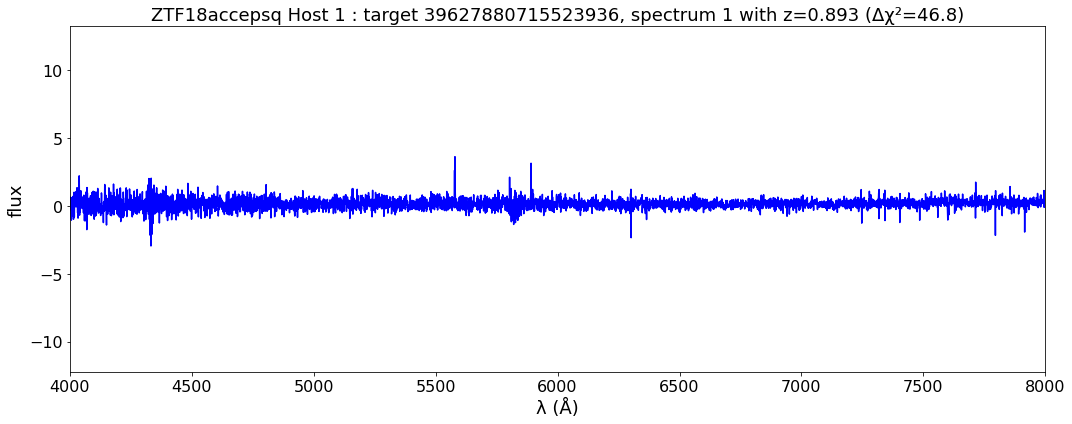

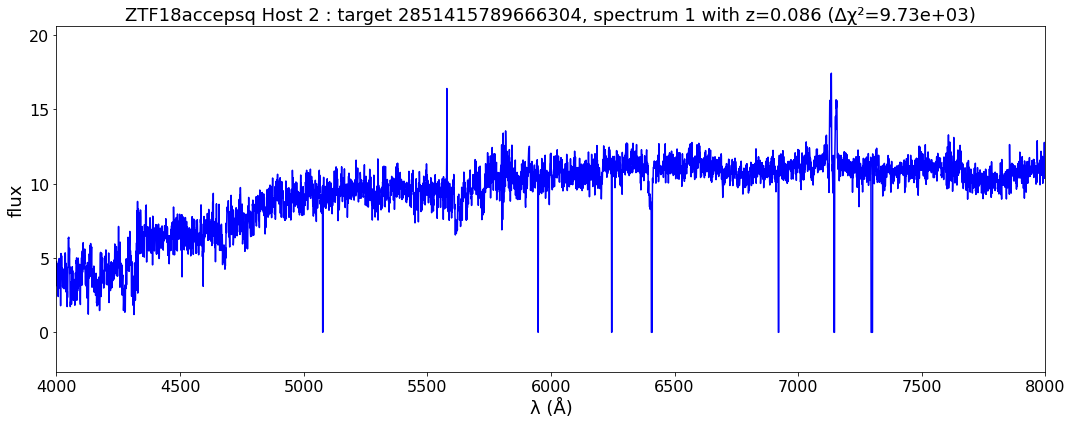

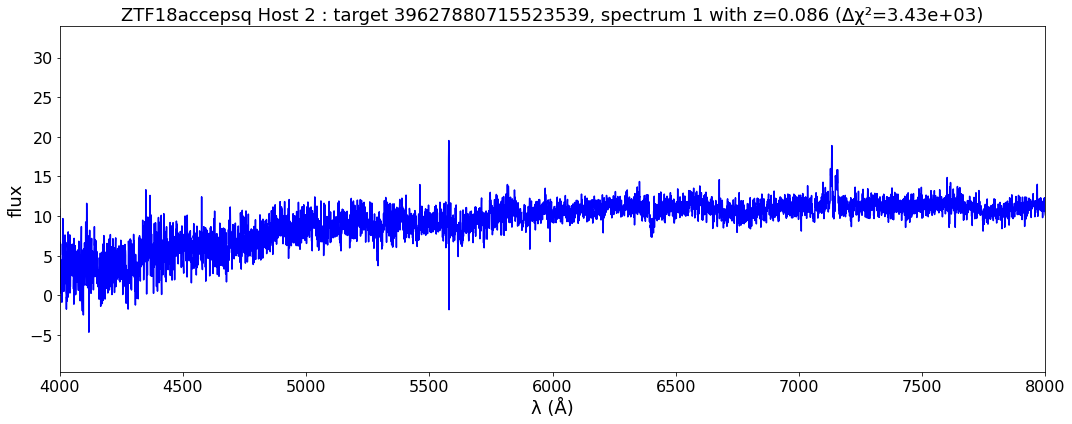

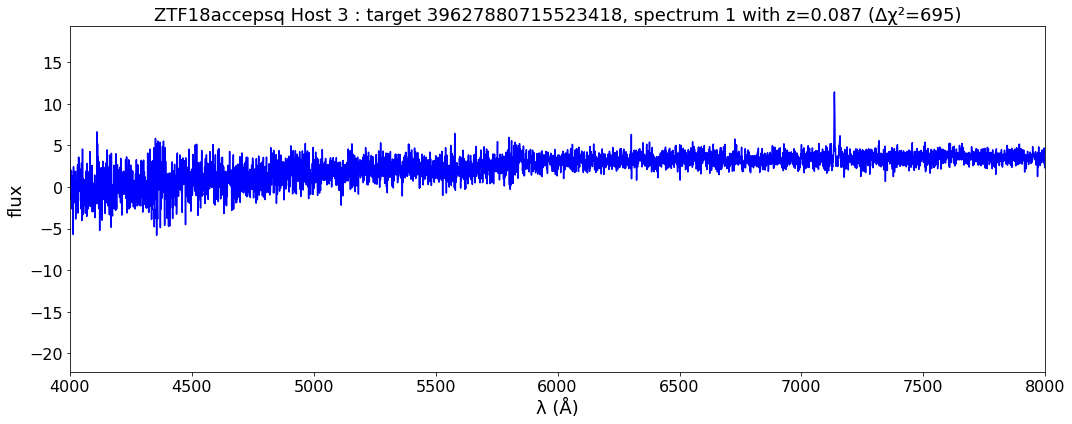

In [66]:
# Plot limits.  Make them None to autoscale
fmin = None
fmax = None
λmin = 4000
λmax = 8000
gausssmooth = 2

for name in names:
    targids = specinfo.targetids_for_name(name)
    print( f"\nTargets for {name}:" )
    for tid in targids:
        infos = specinfo.info_for_targetid( tid )
        specs = specinfo.get_spectra( tid )
        specnum = 0
        for info, spec in zip( infos, specs ):
            specnum += 1
            fig = pyplot.figure( figsize=(15,6), tight_layout=True )
            ax = fig.add_subplot( 1, 1, 1 )
            title = ( f'{name} : target {tid}, spectrum {specnum} '
                      # f'Tile {spec["tileid"]} on night {spec["night"]} '
                      f'with z={info["z"]:.3f}' )
            if info["zwarn"] != 0:
                title += f' (zwarn={info["zwarn"]})'
            title += f' (Δχ²={info["deltachi2"]:.3g})'
            ax.set_title( title, fontsize=18 )
            ax.set_xlabel( 'λ (Å)', fontsize=18 )
            ax.set_ylabel( 'flux', fontsize=18 )
            ax.tick_params( axis='both', labelsize=16 )
            if λmin is not None:
                ax.set_xlim( λmin, λmax )
            if fmin is not None:
                ax.set_ylim( fmin, fmax )
            λ = spec.wave['brz']
            flux = spec.flux['brz'][0, :]
            ax.plot( λ, flux, 'b' )
            fig.show()
